In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [3]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,Xiaomi announces their biggest Redmi online la...,Xiaomi announced the Redmi online launch in wh...,technology
1,OnePlus to unveil its entire lineup of 5G devi...,OnePlus has announced that it will be unveilin...,technology
2,Twitter makes work from home compulsory for it...,Twitter has said that working from home is now...,technology
3,Apple employee tests positive for coronavirus ...,An Apple employee at the company's European he...,technology
4,"Facial recognition tech used to identify 1,100...",Home Minister Amit Shah on Wednesday told the ...,technology
5,Secret-sharing app 'Whisper' left data of mill...,"'Whisper', a secret-sharing app available on b...",technology
6,Escobar Fold 2 phone turns out be Samsung Gala...,Several tech reviewers have revealed that Pabl...,technology
7,Coronavirus is putting a huge strain on medica...,Facebook COO Sheryl Sandberg showed her apprec...,technology
8,Apple closes all 17 stores in Italy amid coron...,Apple announced it will be shutting down all 1...,technology
9,"Apple stores to stop Apple Watch, AirPod try-o...",Apple will limit its store employees from enco...,technology


In [4]:
news_df.news_category.value_counts()

technology    25
sports        25
world         25
Name: news_category, dtype: int64

In [5]:
import spacy
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata
# nltk.download('stopwords')
nlp = spacy.load('en_core_web_md', parse=True, tag=True, entity=True)
#nlp_vec = spacy.load('en_vecs', parse = True, tag=True, #entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [6]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

strip_html_tags('<html><h2>Some important text</h2></html>')

'Some important text'

In [7]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

In [8]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [9]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

In [10]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'My system keep crash hi crash yesterday, our crash daili'

In [11]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'My system keep crash ! his crash yesterday , ours crash daily'

In [12]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

In [13]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [14]:
# combining headline and article text
news_df['full_text'] = news_df["news_headline"].map(str)+ '. ' + news_df["news_article"]

# pre-process text and store the same
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])

# show a sample news article
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': 'OnePlus to unveil its entire lineup of 5G devices at upcoming launch. OnePlus has announced that it will be unveiling a full 5G lineup for its upcoming OnePlus 8 series launch. "We\'re proud to be among the first smartphone manufacturers to have full 5G line up for our next launch," OnePlus Founder and CEO, Pete Lau said. He added that the smartphone experience will \'go through a dramatic development\' owing to 5G.',
 'clean_text': 'oneplus unveil entire lineup g device upcoming launch oneplus announce unveil full g lineup upcoming oneplus series launch proud among first smartphone manufacturer full g line next launch oneplus founder ceo pete lau say add smartphone experience go dramatic development owe g'}

In [15]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

In [16]:
# create a basic pre-processed corpus, don't lowercase to get POS context
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

# demo for POS tagging for sample news headline
sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

# POS tagging with Spacy 
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

# POS tagging with nltk
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,OnePlus,CC
1,to,TO
2,unveil,VB
3,its,PRP$
4,entire,JJ
5,lineup,NN
6,of,IN
7,5G,CD
8,devices,NNS
9,at,IN


In [17]:
from nltk.corpus import conll2000

data = conll2000.chunked_sents()
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [18]:
from nltk.chunk.util import tree2conlltags, conlltags2tree

wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [19]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [20]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

# define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)
  
# train chunker model  
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [21]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  OnePlus/CC
  (VP to/TO unveil/VB)
  (NP its/PRP$ entire/JJ lineup/NN)
  (PP of/IN)
  (NP 5G/CD devices/NNS)
  (PP at/IN)
  (NP upcoming/JJ launch/NN))


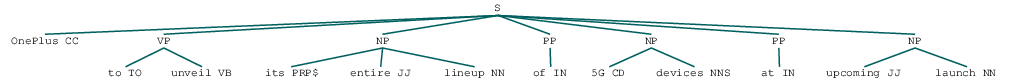

In [22]:
from IPython.display import display

display(chunk_tree)

In [23]:
# set java path
import os
java_path = r'/home/amiel/jdk1.8.0_102/bin/java'
os.environ['JAVAHOME'] = java_path

from nltk.parse.stanford import StanfordParser

scp = StanfordParser(path_to_jar='/home/amiel/stanford/stanford-parser-full-2015-04-20/stanford-parser.jar',
                     path_to_models_jar='/home/amiel/stanford/stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')
                   
result = list(scp.raw_parse(sentence))
print(result[0])

(ROOT
  (S
    (NP (NNS OnePlus))
    (VP
      (TO to)
      (VP
        (VB unveil)
        (NP
          (NP (PRP$ its) (JJ entire) (NN lineup))
          (PP (IN of) (NP (CD 5G) (NNS devices))))
        (PP (IN at) (S (VP (VBG upcoming) (NP (NN launch)))))))))


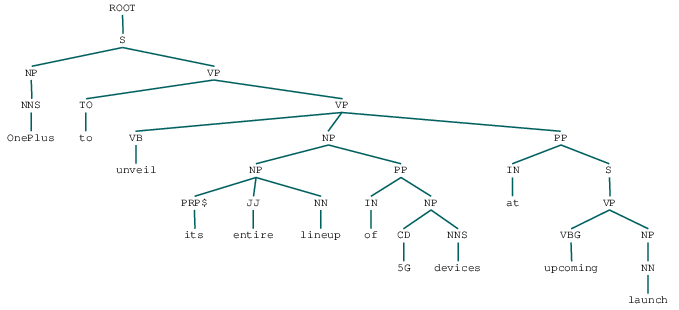

In [24]:
from IPython.display import display
display(result[0])

In [25]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---OnePlus[ROOT]--->['unveil']
--------
[]<---to[aux]--->[]
--------
['to']<---unveil[relcl]--->['lineup', 'at']
--------
[]<---its[poss]--->[]
--------
[]<---entire[amod]--->[]
--------
['its', 'entire']<---lineup[dobj]--->['of']
--------
[]<---of[prep]--->['devices']
--------
[]<---5[nummod]--->[]
--------
[]<---G[compound]--->[]
--------
['5', 'G']<---devices[pobj]--->[]
--------
[]<---at[prep]--->['launch']
--------
[]<---upcoming[amod]--->[]
--------
['upcoming']<---launch[pobj]--->[]
--------


In [26]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

(unveil
  OnePlus
  to
  (lineup its entire (devices of 5G))
  (upcoming at launch))


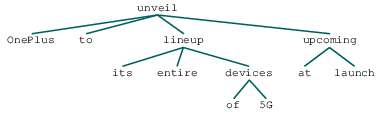

In [27]:
from nltk.parse.stanford import StanfordDependencyParser
sdp = StanfordDependencyParser(path_to_jar='/home/amiel/stanford/stanford-parser-full-2015-04-20/stanford-parser.jar',
                               path_to_models_jar='/home/amiel/stanford/stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')    

result = list(sdp.raw_parse(sentence))  

# print the dependency tree
dep_tree = [parse.tree() for parse in result][0]
print(dep_tree)

# visualize raw dependency tree
from IPython.display import display
display(dep_tree)

# visualize annotated dependency tree (needs graphviz)
# from graphviz import Source
# dep_tree_dot_repr = [parse for parse in result][0].to_dot()
# source = Source(dep_tree_dot_repr, filename="dep_tree", format="png")
# source

In [28]:
sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(OnePlus, 'ORG'), (5, 'CARDINAL'), (OnePlus, 'ORG'), (5, 'CARDINAL'), (OnePlus, 'LAW'), (8, 'LAW'), (series, 'LAW'), (first, 'ORDINAL'), (5, 'CARDINAL'), (OnePlus, 'WORK_OF_ART'), (Founder, 'WORK_OF_ART'), (Pete, 'PERSON'), (Lau, 'PERSON'), (5G., 'CARDINAL')]


In [29]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [30]:
# get the top named entities
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,Apple,first,Google,US,Italy,China,India,UK,IPL,COVID-19,17,Turkey,5,South Africa,Saudi Arabia
Entity Type,ORG,ORDINAL,ORG,GPE,GPE,GPE,GPE,GPE,ORG,NORP,CARDINAL,GPE,CARDINAL,GPE,GPE
Frequency,15,14,9,9,9,7,6,6,5,5,4,4,4,4,4


In [31]:
# get the top named entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,ORG,GPE,PERSON,CARDINAL,DATE,NORP,ORDINAL,MONEY,TIME,LOC,QUANTITY,PERCENT,FAC,WORK_OF_ART,EVENT
Frequency,146,110,90,67,57,36,19,11,10,8,5,4,4,3,2


In [32]:
from nltk.tag import StanfordNERTagger
import os

# set java path
java_path = r'/home/amiel/jdk1.8.0_102/bin/java'
os.environ['JAVAHOME'] = java_path

# initialize NER tagger
sn = StanfordNERTagger('/home/amiel/stanford/stanford-ner-2014-08-27/classifiers/english.all.3class.distsim.crf.ser.gz',
                       path_to_jar='/home/amiel/stanford/stanford-ner-2014-08-27/stanford-ner.jar')

# tag named entities
ner_tagged_sentences = [sn.tag(sent.split()) for sent in corpus]

# extract all named entities
named_entities = []
for sentence in ner_tagged_sentences:
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in sentence:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

#named_entities = list(set(named_entities))
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])
                            

# view top entities and types
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head(15)


# view top entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head()

,Entity Type,Frequency
0,LOCATION,117
1,ORGANIZATION,95
2,PERSON,81


In [33]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn()

# compute sentiment scores (polarity) and labels
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]
    
    
# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                           
                        count  mean       std   min  25%  50%  75%   max
news_category                                                           
sports                   25.0  0.40  6.006940 -16.0 -2.0  1.0  3.0  17.0
technology               25.0 -0.44  6.021351 -19.0 -2.0  1.0  3.0   8.0
world                    25.0 -3.12  5.325411 -15.0 -6.0 -3.0  0.0   7.0

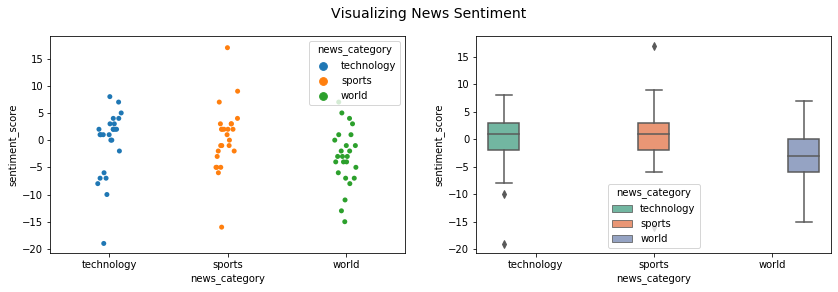

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

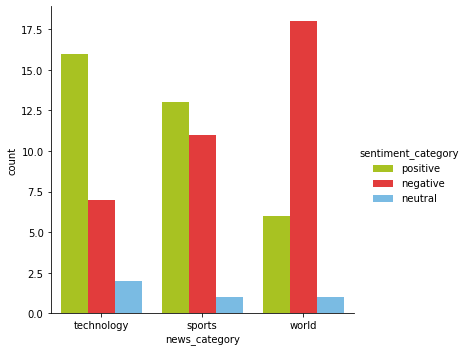

In [35]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [41]:
pos = int(max(df.sentiment_score))
neg = int(min(df.sentiment_score))
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == pos)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == neg)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: Home Minister Amit Shah on Wednesday told the Lok Sabha that Delhi Police are using facial recognition software to identify the rioters involved in Northeast Delhi violence. "We have also fed Aadhaar and driving license data into this software, which has identified 1,100 people. Out of these, 300 people came from Uttar Pradesh to carry out violence," Shah said.

Most Positive Tech News Article: Home Minister Amit Shah on Wednesday told the Lok Sabha that Delhi Police are using facial recognition software to identify the rioters involved in Northeast Delhi violence. "We have also fed Aadhaar and driving license data into this software, which has identified 1,100 people. Out of these, 300 people came from Uttar Pradesh to carry out violence," Shah said.


In [42]:
pos = int(max(df.sentiment_score))
neg = int(min(df.sentiment_score))
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == pos)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == neg)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: Italy has shut down all its stores except for basic necessities like pharmacies and food shops in order to contain the spread of the coronavirus, Prime Minister Giuseppe Conte said. This comes after the country reported over 12,000 cases and the death toll rose to 827. Earlier, Conte's government pledged to spend up to $28 billion to fight the disease.

Most Positive World News Article: Italy has shut down all its stores except for basic necessities like pharmacies and food shops in order to contain the spread of the coronavirus, Prime Minister Giuseppe Conte said. This comes after the country reported over 12,000 cases and the death toll rose to 827. Earlier, Conte's government pledged to spend up to $28 billion to fight the disease.


In [43]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                                 \
                        count     mean       std    min    25%    50%    75%   
news_category                                                                  
sports                   25.0  0.09160  0.143751 -0.130 -0.030  0.065  0.242   
technology               25.0  0.05424  0.149176 -0.244 -0.025  0.000  0.150   
world                    25.0  0.01796  0.137037 -0.318 -0.075  0.000  0.105   

                      
                 max  
news_category         
sports         0.318  
technology     0.358  
world          0.333

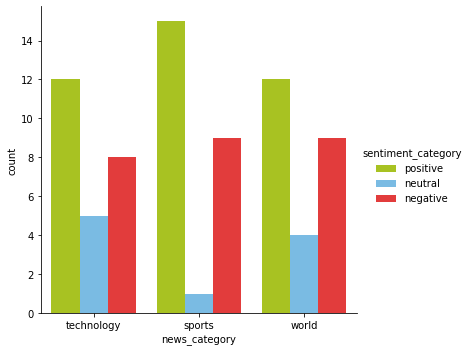

In [44]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [45]:
pos = int(max(df.sentiment_score))
neg = int(min(df.sentiment_score))
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == pos)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == neg)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: Italy has shut down all its stores except for basic necessities like pharmacies and food shops in order to contain the spread of the coronavirus, Prime Minister Giuseppe Conte said. This comes after the country reported over 12,000 cases and the death toll rose to 827. Earlier, Conte's government pledged to spend up to $28 billion to fight the disease.

Most Positive World News Article: Italy has shut down all its stores except for basic necessities like pharmacies and food shops in order to contain the spread of the coronavirus, Prime Minister Giuseppe Conte said. This comes after the country reported over 12,000 cases and the death toll rose to 827. Earlier, Conte's government pledged to spend up to $28 billion to fight the disease.
